In [143]:
import os
import csv
from collections import defaultdict, Counter
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu
import math

In [144]:
LOGS = '/mnt/data0/lucy/gpt3_bias/logs/'
prompts_path = LOGS + 'original_prompts/'

## Character name popularity

In [5]:
def get_named_entities(char_neighbor_path): 
    '''
    Count named entities once per story
    '''
    named_people = Counter()
    for f in os.listdir(char_neighbor_path):
        all_people = set()
        with open(char_neighbor_path + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                all_people.add(neighbor['character_name'])
                for al in neighbor['aliases']: 
                    all_people.add(al)
        for person in all_people: 
            name = '_'.join(person.split('_')[:-1])
            named_people[name] += 1
    return named_people

In [4]:
def plot_popular_names(char_neighbor_path, title): 
    plt.figure(dpi=150, figsize=(6,6))
    people = get_named_entities(char_neighbor_path)
    total_names = sum(list(people.values()))
    labels = []
    values = []
    for tup in people.most_common(20): 
        labels.append(tup[0])
        values.append(tup[1]/total_names)
    labels = labels[::-1]
    values = values[::-1]
    x = np.arange(len(labels))
    plt.barh(x, values, 0.7)
    plt.xlabel('Percentage of names')
    plt.title(title)
    plt.yticks(x, labels=labels, fontsize=12)
    plt.show()

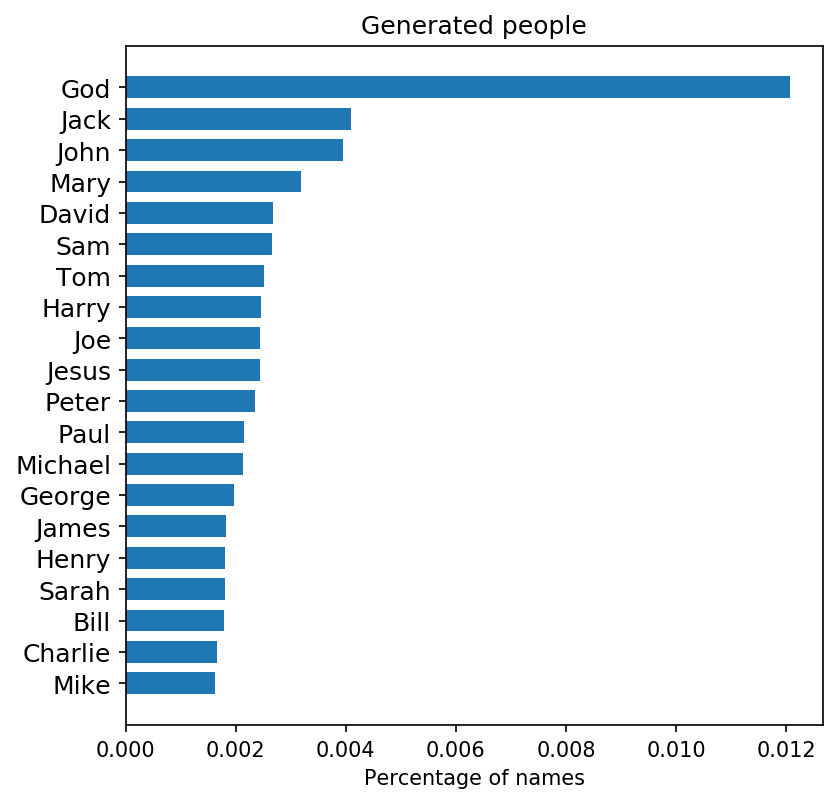

In [5]:
plot_popular_names(LOGS + 'char_neighbors_0.9/', 'Generated people')

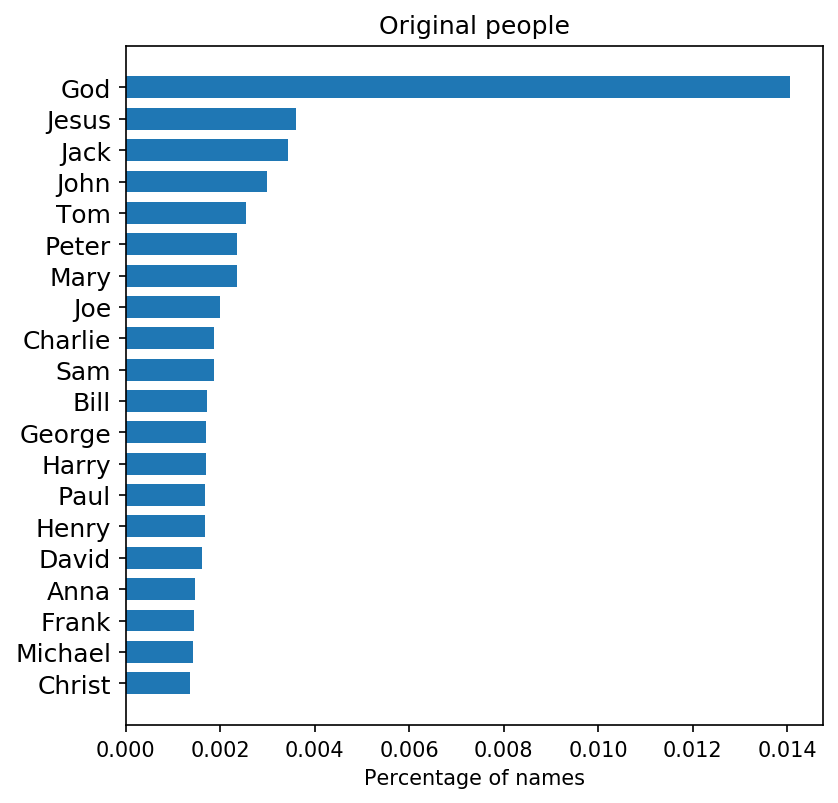

In [6]:
plot_popular_names(LOGS + 'orig_char_neighbors/', 'Original people')

## Character networks

In [100]:
def get_char_network(char_neighbor_path): 
    # gender type is "name" or "pronouns"
    d = {'main_gender':[], 'fem count':[], 'masc count':[], 'mixed pronouns count':[], 
        'other (name) count': [], 'masc (name) count': [], 'fem (name) count': []}
    all_n_genders = ['mixed pronouns', 'other (name)', 'masc (name)', 'fem (name)', 'fem', 'masc']
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            main_char_gender = defaultdict(str) # story ID to gender
            neighbor_dict = char_neighbors[char]
            neighbor_genders = defaultdict(list) # story ID to neighbor genders
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al == char: 
                            is_main = True
                if is_main: 
                    if gender.startswith('mixed') or gender.startswith('other'): 
                        gender = 'other'
                    main_char_gender[story_ID] = gender
                    continue
                    
                if pronoun_count == 0 and not gender.endswith('(name)'): 
                    gender += ' (name)'
                neighbor_genders[story_ID].append(gender)
                
            for story_ID in main_char_gender: 
                main_g = main_char_gender[story_ID]
                n_genders = Counter(neighbor_genders[story_ID])
                total = sum(list(n_genders.values()))
                if total == 0: continue
                d['main_gender'].append(main_g)
                for gender in all_n_genders: 
                    d[gender + ' count'].append(n_genders[gender])
    return d

In [232]:
gen_d = get_char_network(LOGS + 'char_gender_0.9/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_stats = gen_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
gen_df

,main_gender,fem count,masc count,mixed pronouns count,other (name) count,masc (name) count,fem (name) count
0,other,1,2,0,0,2,1
1,masc,1,0,0,0,0,0
2,masc,0,2,0,2,2,4
3,masc,0,5,0,3,1,1
4,other,1,1,0,0,1,0
...,...,...,...,...,...,...,...
103166,masc,1,3,0,2,0,0
103167,fem,0,0,0,1,0,0
103168,fem,0,5,0,2,3,3
103169,fem,4,3,0,2,0,2


In [271]:
orig_d = get_char_network(LOGS + 'orig_char_gender/')
orig_df = pd.DataFrame.from_dict(orig_d)
orig_stats = orig_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
orig_df

,main_gender,fem count,masc count,mixed pronouns count,other (name) count,masc (name) count,fem (name) count
0,masc,7,4,0,1,4,0
1,masc,1,2,0,7,2,1
2,masc,3,0,0,1,0,0
3,masc,0,2,1,0,0,0
4,masc,6,0,0,1,2,2
...,...,...,...,...,...,...,...
21440,fem,2,2,0,0,3,0
21441,other,2,2,0,1,1,5
21442,fem,2,3,0,0,2,3
21443,fem,1,3,0,0,3,1


In [263]:
def get_values(gender, stats):
    '''
    gender is main character gender, such as 'fem', 'masc', or 'other'
    '''
    c = stats.loc[gender].loc['fem count'].loc['count']
    name_means = [stats.loc[gender].loc['masc (name) count'].loc['mean'], 
                  stats.loc[gender].loc['fem (name) count'].loc['mean'], 
                  stats.loc[gender].loc['other (name) count'].loc['mean']]
    name_ci = [stats.loc[gender].loc['masc (name) count'].loc['std'], 
                  stats.loc[gender].loc['fem (name) count'].loc['std'], 
                  stats.loc[gender].loc['other (name) count'].loc['std']]
    for i in range(len(labels)): 
        name_ci[i] = 1.96*name_ci[i]/math.sqrt(c)
    pronoun_means = [stats.loc[gender].loc['masc count'].loc['mean'], 
                     stats.loc[gender].loc['fem count'].loc['mean'], 
                     stats.loc[gender].loc['mixed pronouns count'].loc['mean']]
    pronoun_ci = [stats.loc[gender].loc['masc count'].loc['std'], 
                     stats.loc[gender].loc['fem count'].loc['std'], 
                     stats.loc[gender].loc['mixed pronouns count'].loc['std']]
    for i in range(len(labels)): 
        pronoun_ci[i] = 1.96*pronoun_ci[i]/math.sqrt(c)
    return name_means, name_ci, pronoun_means, pronoun_ci

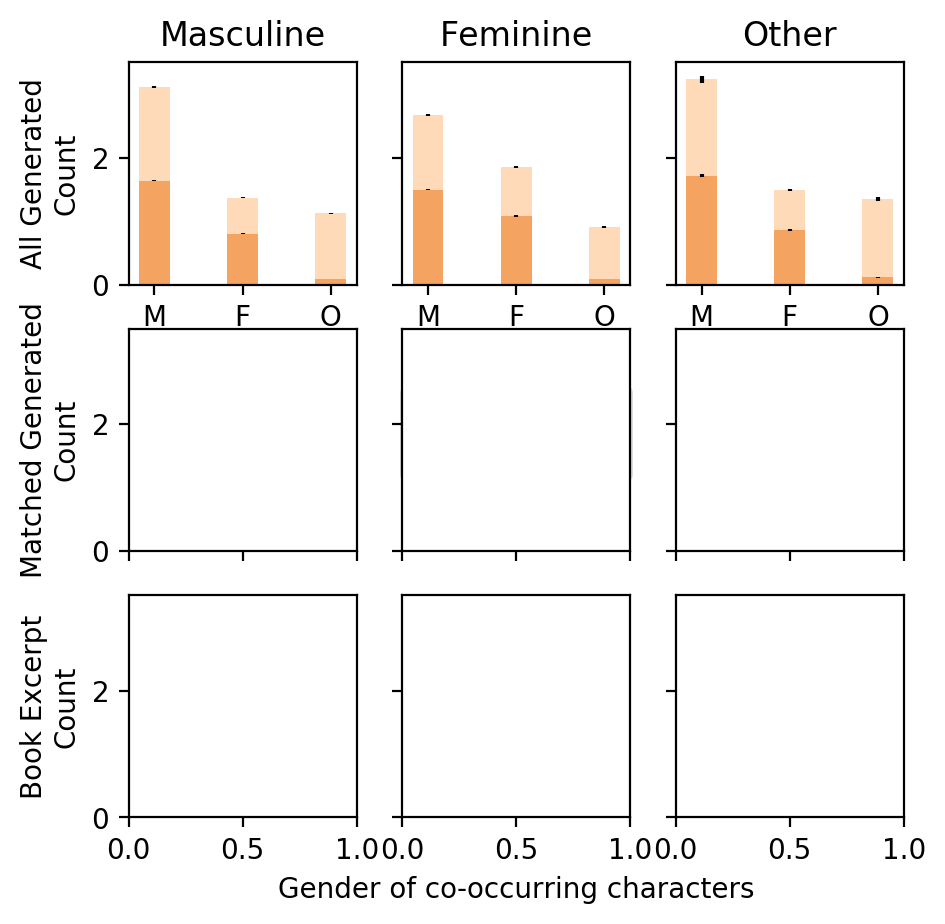

In [282]:
# https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/bar_stacked.html
fig, axes = plt.subplots(3, 3, figsize=(5, 5), dpi=200)
bar_width = 0.35
for i in range(3): 
    for j in range(3): 
        axes[i][j].set_ylim(0, 3.5)
labels = ['M', 'F', 'O']

name_means, name_ci, pronoun_means, pronoun_ci = get_values('masc', gen_stats)
axes[0][0].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][0].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')

axes[0][0].set_ylabel('All Generated\nCount')
axes[0][0].set_title('Masculine')

name_means, name_ci, pronoun_means, pronoun_ci = get_values('fem', gen_stats)
axes[0][1].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][1].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')

axes[0][1].get_yaxis().set_ticklabels([])
axes[0][1].set_title('Feminine')
axes[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4))

name_means, name_ci, pronoun_means, pronoun_ci = get_values('other', gen_stats)
axes[0][2].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][2].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')

axes[0][2].get_yaxis().set_ticklabels([])
axes[0][2].set_title('Other')

axes[1][0].set_ylabel('Matched Generated\nCount')
axes[1][0].get_xaxis().set_ticklabels([])

axes[1][1].get_xaxis().set_ticklabels([])
axes[1][1].get_yaxis().set_ticklabels([])

axes[1][2].get_xaxis().set_ticklabels([])
axes[1][2].get_yaxis().set_ticklabels([])

axes[2][0].set_ylabel('Book Excerpt\nCount')

axes[2][1].get_yaxis().set_ticklabels([])

axes[2][2].get_yaxis().set_ticklabels([])
axes[2][1].set_xlabel('Gender of co-occurring characters')

plt.show()

In [267]:
# main character genders
print("Women:", d['main_gender'].count('fem'), d['main_gender'].count('fem')/len(d['main_gender']))
print("Men:", d['main_gender'].count('masc'), d['main_gender'].count('masc')/len(d['main_gender']))
print("Other:", d['main_gender'].count('other'), d['main_gender'].count('other')/len(d['main_gender']))
print("Total:", len(d['main_gender']))

Women: 33059 0.3204291903732638
Men: 57463 0.5569685279778233
Other: 12649 0.12260228164891297
Total: 103171


## Topics

In [146]:
def get_topic_by_dataset():
    topic_dir = LOGS + 'topics_0.9'
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    data_topics = {'dataset':[], 'topic':[], 'value':[]}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]             
        assert len(topics) == 50
        for topic_id, value in enumerate(topics): 
            if story_title_id.startswith('ORIG_'):
                data_topics['dataset'].append('original')
            else: 
                data_topics['dataset'].append('generated')
            data_topics['topic'].append(topic_id)
            data_topics['value'].append(value)
    return data_topics

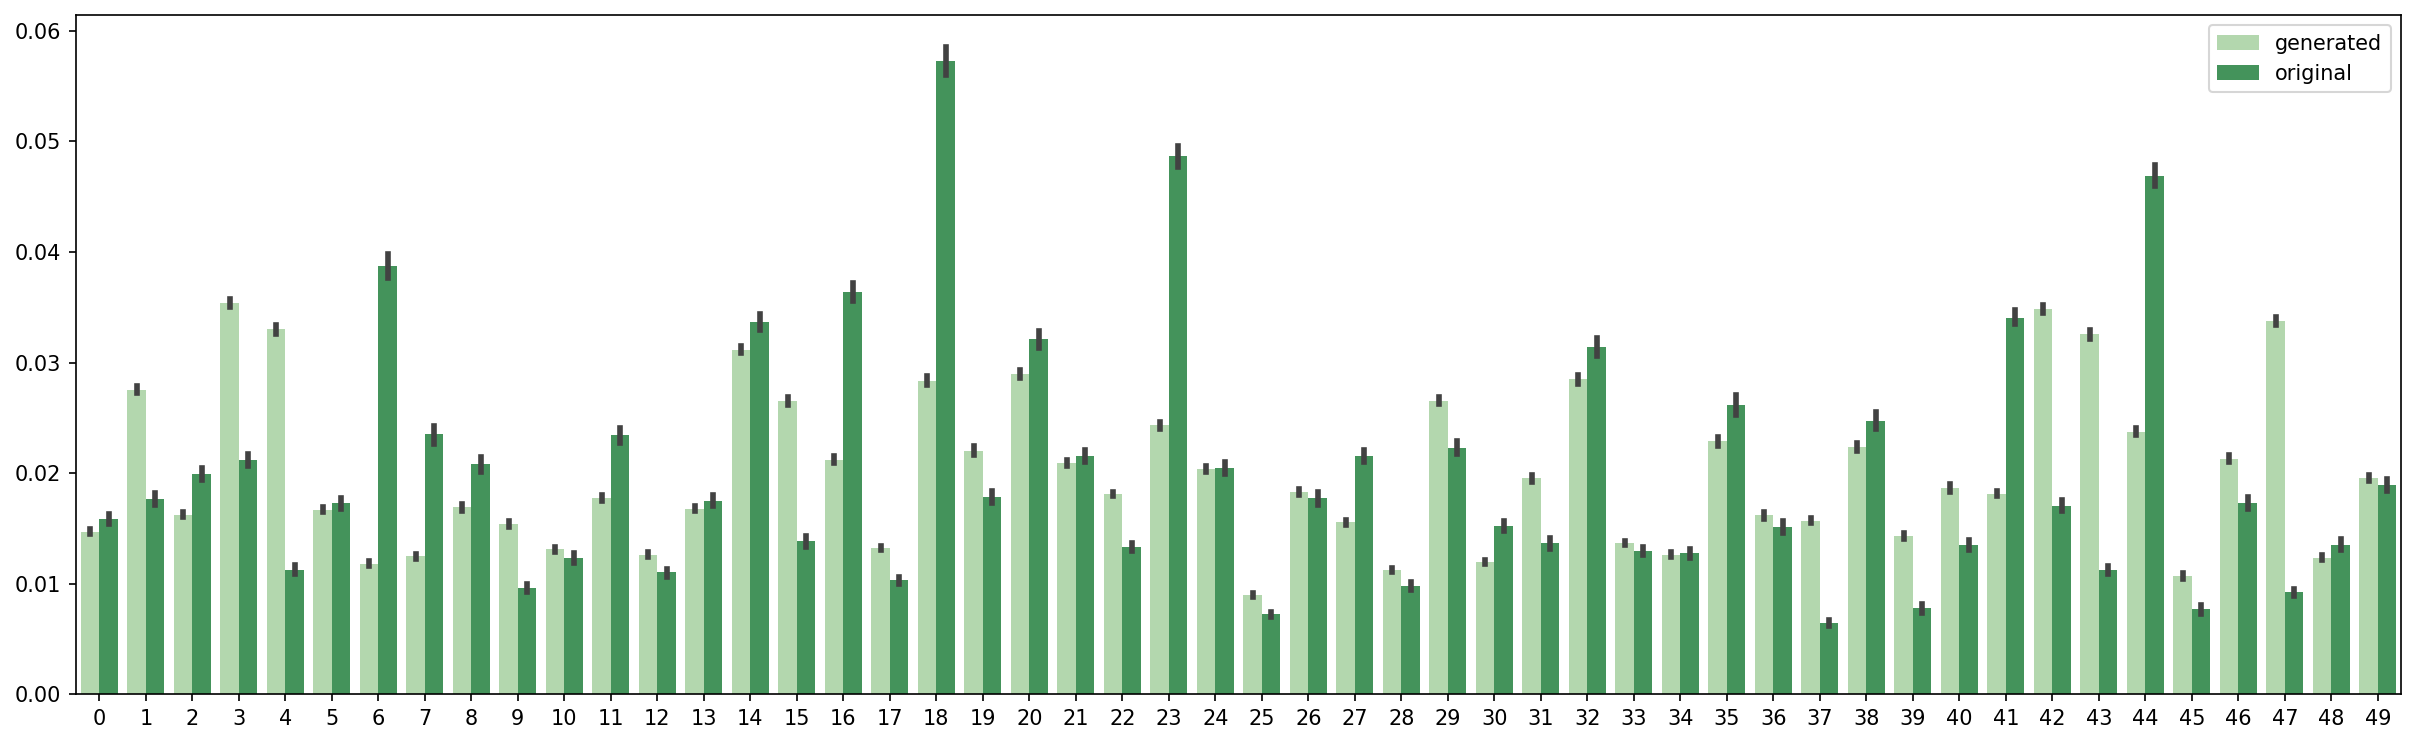

In [94]:
data_topics = get_topic_by_dataset()
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Greens", hue="dataset", data=data_topics)

In [148]:
with open(LOGS + 'gender_topics_0.9.json', 'r') as infile: 
    gen_gender_topics = json.load(infile)
with open(LOGS + 'orig_gender_topics.json', 'r') as infile: 
    orig_gender_topics = json.load(infile)
with open(LOGS + 'gender_topics_0.9_matched.json', 'r') as infile: 
    matched_gender_topics = json.load(infile)

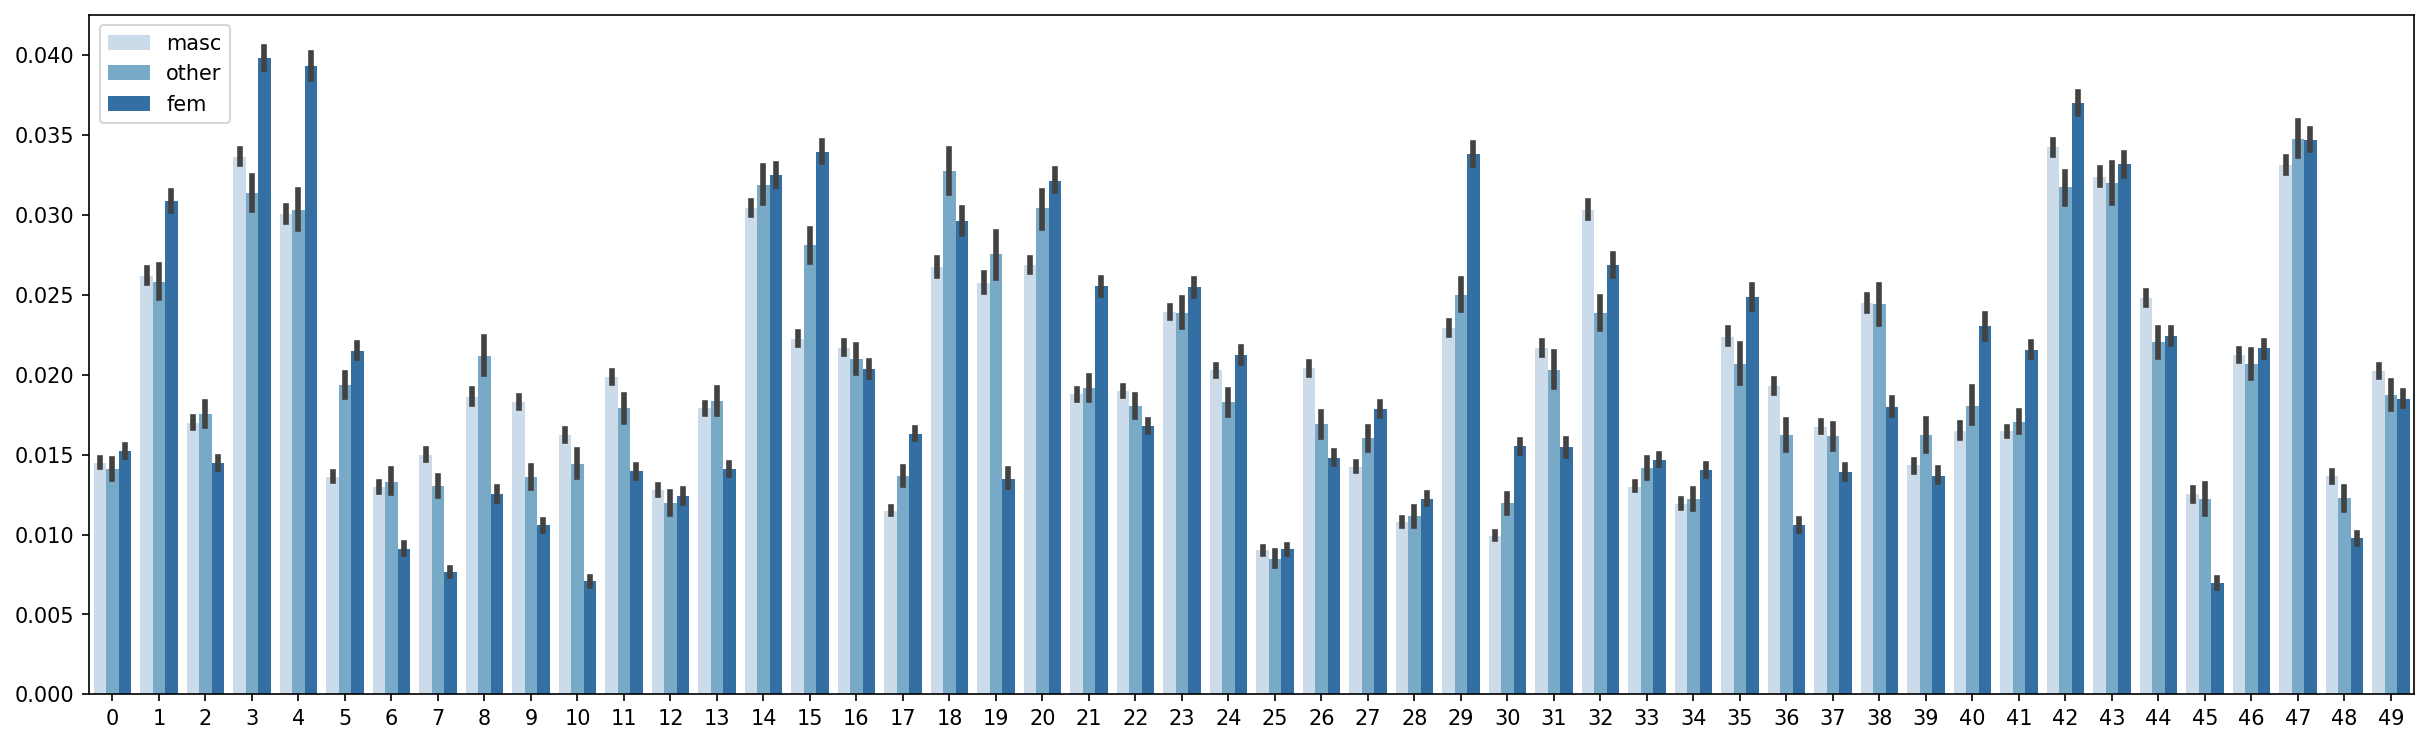

In [42]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=gen_gender_topics)

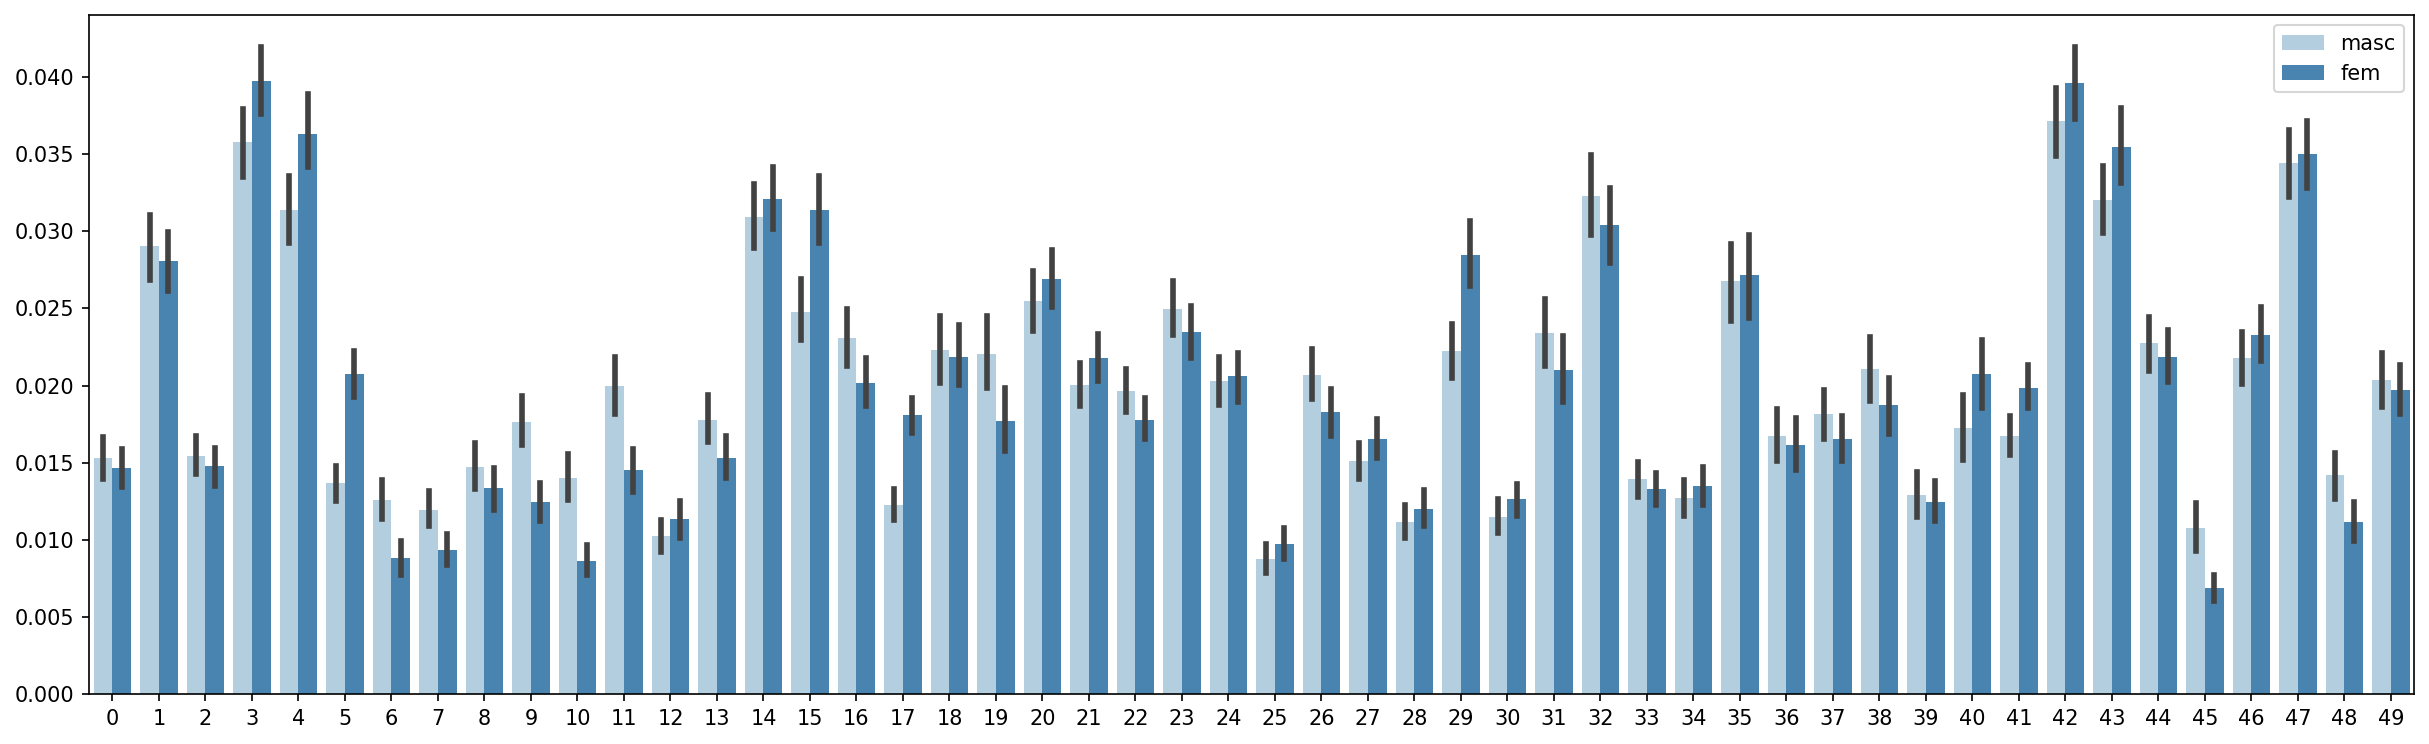

In [149]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=matched_gender_topics)

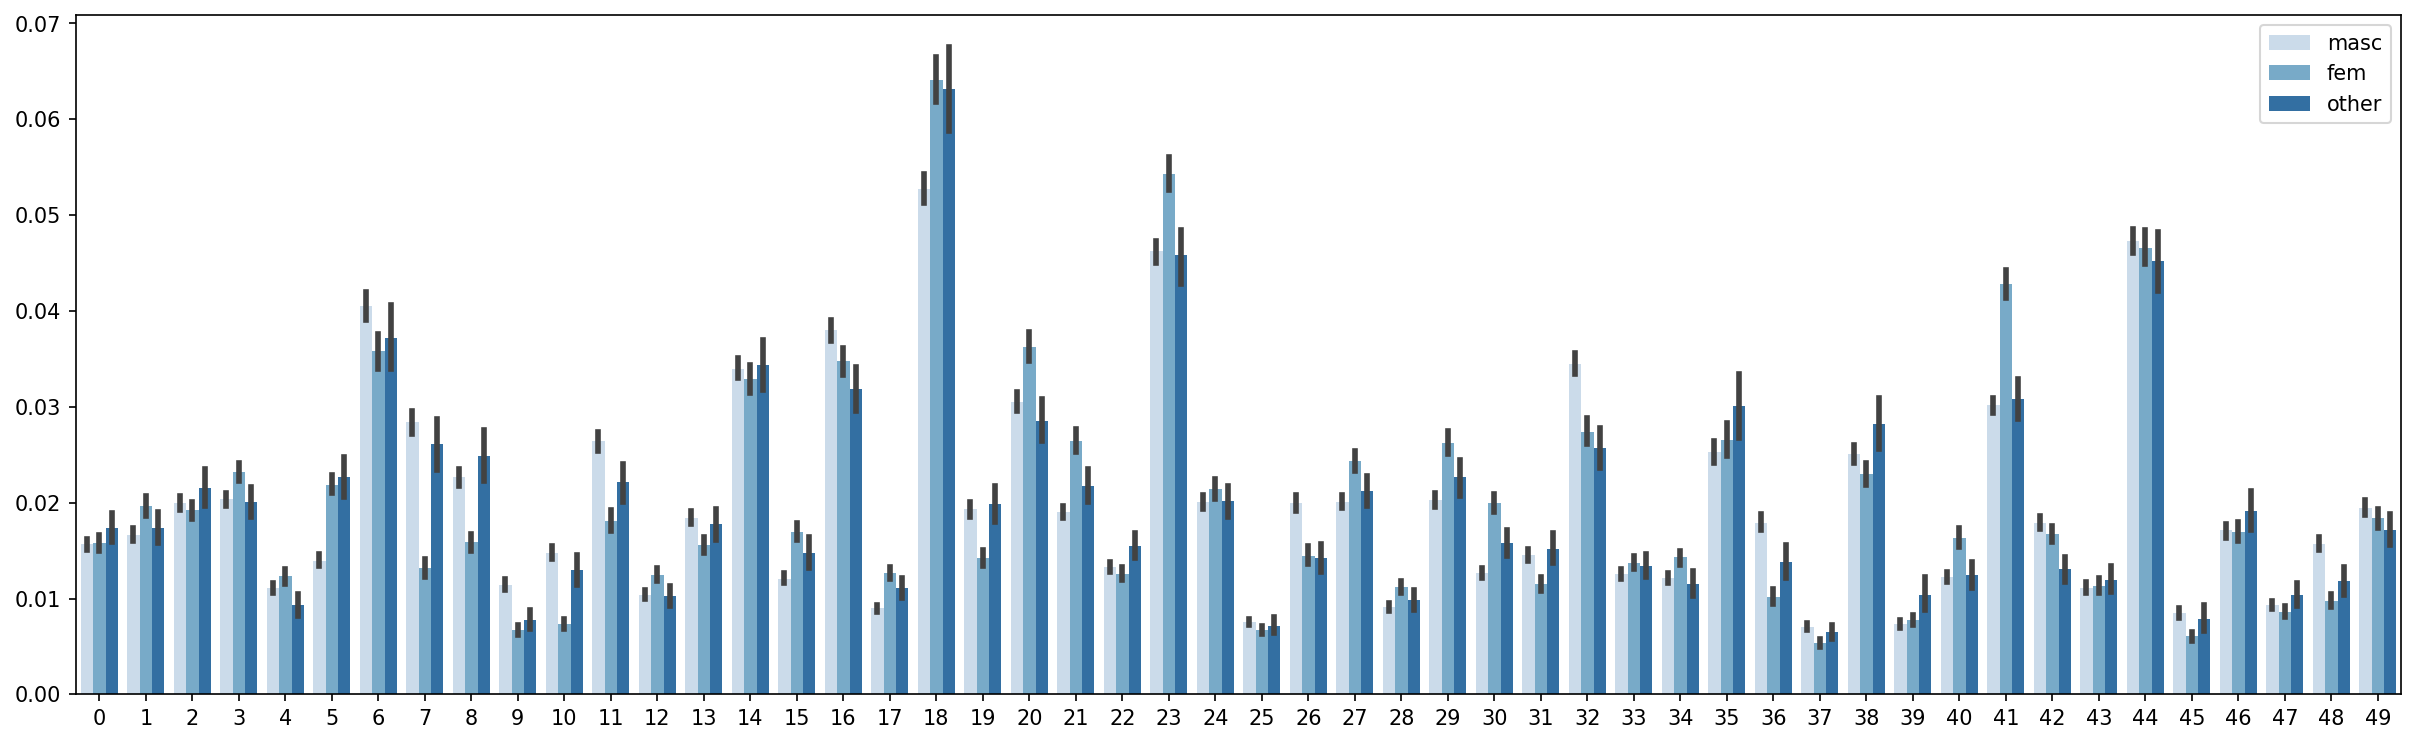

In [43]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=orig_gender_topics)

In [150]:
gender_df = pd.DataFrame(gen_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
diffs = {'dataset':[], 'diff':[], 'topic':[]}
gen_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('generated')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        gen_diffs[topic] = diff
        
gender_df = pd.DataFrame(orig_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
orig_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('original')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        orig_diffs[topic] = diff
        
gender_df = pd.DataFrame(matched_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
matched_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('matched')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        matched_diffs[topic] = diff

orig_diffs = [tup[1] for tup in sorted(orig_diffs.items(), key=lambda item: item[0])]
gen_diffs = [tup[1] for tup in sorted(gen_diffs.items(), key=lambda item: item[0])]
matched_diffs = [tup[1] for tup in sorted(matched_diffs.items(), key=lambda item: item[0])]

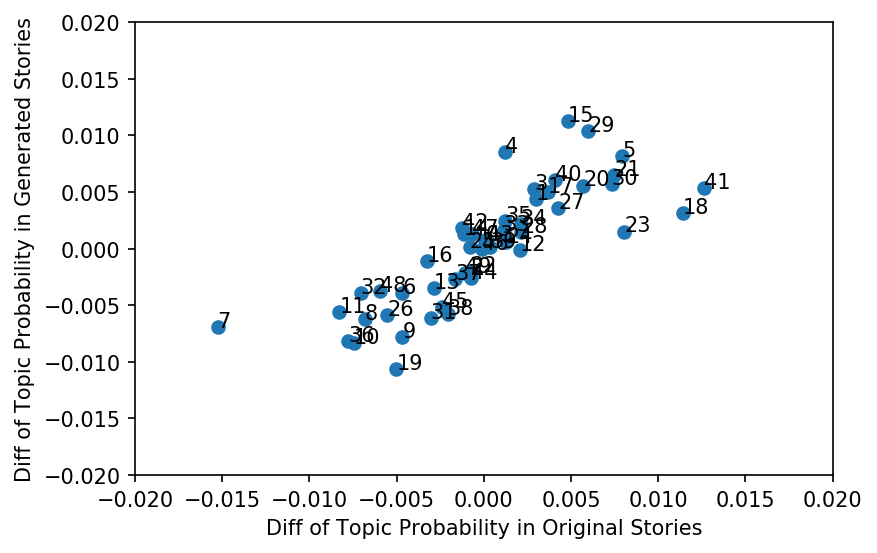

(0.8150961486927619, 5.805724681580592e-13)


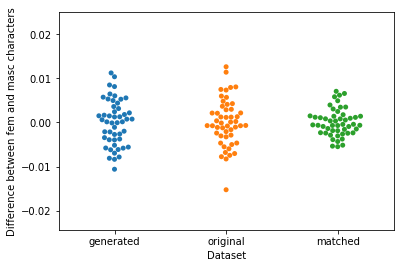

In [151]:
plt.figure(dpi=150)
plt.scatter(orig_diffs, gen_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (orig_diffs[i], gen_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Original Stories")
plt.ylabel("Diff of Topic Probability in Generated Stories")
plt.show()
print(pearsonr(orig_diffs, gen_diffs))
sns.swarmplot(x="dataset", y="diff", data=diffs)
plt.ylabel("Difference between fem and masc characters")
plt.xlabel("Dataset")
plt.show()

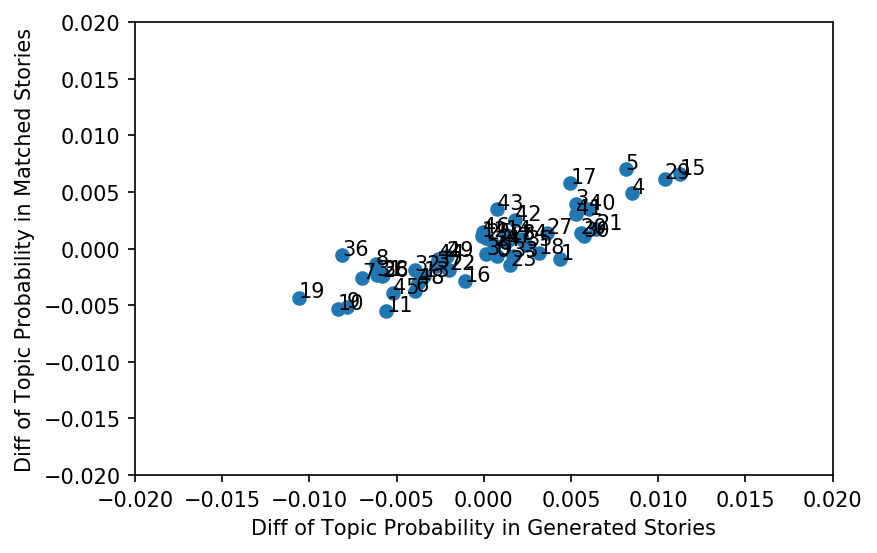

(0.8682460352853983, 3.2089866878480976e-16)


In [155]:
plt.figure(dpi=150)
plt.scatter(gen_diffs, matched_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (gen_diffs[i], matched_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Generated Stories")
plt.ylabel("Diff of Topic Probability in Matched Stories")
plt.show()
print(pearsonr(matched_diffs, gen_diffs))

In [98]:
print(np.argsort(orig_diffs))
print(np.sort(orig_diffs))

[ 7 11 36 10 32  8 48 26 19  6  9 16 31 13 45 38 37 42 14 49 25  2 22 44
 47 46  0 43 39 33 35  4 24 12 34 28  3  1 17 40 27 15 20 29 30 21  5 23
 18 41]
[-1.52708451e-02 -8.28648240e-03 -7.77179611e-03 -7.46380967e-03
 -7.05626341e-03 -6.81795595e-03 -5.97727003e-03 -5.52681578e-03
 -5.01904456e-03 -4.68007774e-03 -4.67288544e-03 -3.27558536e-03
 -3.05491495e-03 -2.87700935e-03 -2.41194156e-03 -2.07891069e-03
 -1.64465632e-03 -1.22952569e-03 -1.12536540e-03 -1.05574937e-03
 -8.13611148e-04 -7.53394210e-04 -7.46617184e-04 -7.17981715e-04
 -6.83133543e-04 -1.30532761e-04  8.30743918e-05  2.07922585e-04
  3.69433549e-04  1.14927930e-03  1.21082914e-03  1.23588774e-03
  1.30093407e-03  2.08499733e-03  2.12632688e-03  2.15401468e-03
  2.87249871e-03  2.97825320e-03  3.66712934e-03  4.10084687e-03
  4.26491036e-03  4.81517934e-03  5.68973100e-03  5.98040131e-03
  7.34190914e-03  7.48435623e-03  7.93536238e-03  8.05736123e-03
  1.13987971e-02  1.26327396e-02]


In [99]:
print(np.argsort(gen_diffs))
print(np.sort(gen_diffs))

[19 10 36  9  7  8 31 26 38 11 45 32  6 48 13 37 44  2 49 22 16 12 46 39
 25 24  0 43 47 14 28 23 33 42 34 35 18 27  1 17  3 41 20 30 40 21  5  4
 29 15]
[-1.06167887e-02 -8.36910791e-03 -8.12585001e-03 -7.84073030e-03
 -6.96736177e-03 -6.20240817e-03 -6.14852020e-03 -5.82958840e-03
 -5.79907599e-03 -5.59141851e-03 -5.18148853e-03 -3.96128518e-03
 -3.92788277e-03 -3.76920450e-03 -3.44778868e-03 -2.72586966e-03
 -2.61999124e-03 -2.15288868e-03 -2.11588679e-03 -1.98657174e-03
 -1.10437037e-03 -1.12218190e-04 -5.93634307e-05  1.32871686e-04
  1.43378106e-04  6.02470962e-04  7.49641296e-04  7.61530850e-04
  1.24910276e-03  1.28402914e-03  1.48089711e-03  1.50624211e-03
  1.64778422e-03  1.79590886e-03  2.17408130e-03  2.42759993e-03
  3.14742409e-03  3.60449510e-03  4.38606699e-03  4.96500250e-03
  5.26660413e-03  5.31258925e-03  5.56328139e-03  5.73513212e-03
  6.03407629e-03  6.45926363e-03  8.13399474e-03  8.49741942e-03
  1.03635267e-02  1.12312450e-02]


In [157]:
print(np.argsort(matched_diffs))
print(np.sort(matched_diffs))

[11 10  9 19 45  6 48 16  7 13 26 31 38 32 22 37 23  8  1 44  2  0 49 33
 36 39 18 24 35 47 34 28 25 12 30 14 27 20 46 21 42 41 43 40  3  4 17 29
 15  5]
[-0.00549564 -0.00537458 -0.0051586  -0.00432666 -0.00390386 -0.00377051
 -0.00305552 -0.00288567 -0.00262462 -0.00244966 -0.00241539 -0.00236493
 -0.00232763 -0.00187418 -0.00185138 -0.00157035 -0.00148791 -0.0013793
 -0.00092365 -0.0009062  -0.00070187 -0.00068257 -0.00064584 -0.00064446
 -0.00056238 -0.00044224 -0.00042307  0.00032917  0.00034724  0.00055263
  0.00080441  0.00082061  0.00094641  0.0010745   0.00114601  0.00117892
  0.0014056   0.00140677  0.0014831   0.00175214  0.00248686  0.00305429
  0.00345711  0.00348929  0.00395943  0.00491838  0.00582218  0.00618114
  0.00656981  0.00706269]


In [21]:
gender_df = pd.DataFrame.from_dict(gender_topics)

In [23]:
topic_29 = gender_df[gender_df['topic'] == 29]
#topic_29['value']
topic_29

,gender,topic,value
29,masc,29,0.274048
79,masc,29,0.274048
129,masc,29,0.274048
179,masc,29,0.274048
229,masc,29,0.274048
...,...,...,...
2324779,masc,29,0.274048
2324829,masc,29,0.274048
2324879,masc,29,0.274048
2324929,masc,29,0.274048


## Lexicons

In [22]:
def read_stereotypes(): 
    inpath = '/mnt/data0/corpora/lexicons/fast_icwsm_2016_gender_stereotypes.csv'
    labels = set(['weak', 'dependent', 'submissive', 'afraid', 'strong', 'dominant', 'beautiful', 'sexual'])
    lexicons = defaultdict(set)
    with open(inpath, 'r') as infile: 
        reader = csv.DictReader(infile, delimiter=',')
        for row in reader: 
            for key in row:
                if row[key] == '': continue 
                if key in labels: 
                    lexicons[key].add(row[key])
    inpath = '/mnt/data0/corpora/lexicons/empath_categories.tsv'
    with open(inpath, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            if 'intellectual' in contents: 
                for w in contents: 
                    lexicons['intellectual'].add(w)
    for key in lexicons: 
        lexicons[key].add(key)
        
    axes_A1 = ['strong', 'dominant']
    axes_A2 = ['weak', 'dependent', 'submissive', 'afraid']
    axes_B1 = ['beautiful', 'sexual']
    axes_B2 = ['intellectual']
    lexicon_d  = defaultdict(set)
    lexicon_d['strong'] = lexicons['strong'] | lexicons['dominant']
    for cat in axes_A2: 
        lexicon_d['weak'] |= lexicons[cat]
    lexicon_d['physical'] = lexicons['beautiful'] | lexicons['sexual']
    lexicon_d['intellectual'] = lexicons['intellectual']
    return lexicon_d

In [23]:
lexicon_d = read_stereotypes()

In [25]:
for k in lexicon_d: print(k, len(lexicon_d[k]))

strong 113
weak 141
physical 201
intellectual 98


In [37]:
genpath = LOGS + 'generated_adj_noun/'
frames = []
d = {'gender':[], 'lexicon':[], 'value':[], 'story':[]}
word_counts = defaultdict(Counter) # (gender, lexicon) : word : count
for f in os.listdir(genpath):
    title = f.replace('.tokens', '')
    gen_word = Counter() # (gender, lexicon, storyid) : count 
    total_counts = Counter() # (gender, storyid) : count
    with open(genpath + f, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            w = contents[0]
            deprel = contents[3]
            hw = contents[5]
            storyid = contents[7]
            gender = contents[8]
            if deprel == 'amod': 
                keyword = w
            elif deprel == 'nsubj': 
                keyword = hw
            total_counts[(gender, storyid)] += 1
            for k in lexicon_d: 
                if keyword in lexicon_d[k]: 
                    gen_word[(gender, k, storyid)] += 1
                    word_counts[(gender, k)][keyword] += 1
    for k in gen_word: 
        gender, lexicon, storyid = k
        frac = gen_word[k] / float(total_counts[(gender, storyid)])
        d['gender'].append(gender)
        d['lexicon'].append(lexicon)
        d['value'].append(frac)
        d['story'].append(title + '_' + storyid)

In [35]:
df = pd.DataFrame.from_dict(d)
df

,gender,lexicon,value,story
0,masc,weak,0.043478,deeping_the_bridge_of_desire_0
1,masc,strong,0.100000,deeping_the_bridge_of_desire_2
2,masc,physical,0.100000,deeping_the_bridge_of_desire_2
3,masc,weak,0.100000,deeping_the_bridge_of_desire_2
4,fem,strong,0.333333,deeping_the_bridge_of_desire_2
...,...,...,...,...
167577,masc,physical,0.035714,cliff_no_telephone_to_heaven_98
167578,fem,strong,0.046512,cliff_no_telephone_to_heaven_98
167579,fem,physical,0.069767,cliff_no_telephone_to_heaven_98
167580,masc,weak,0.035714,cliff_no_telephone_to_heaven_98


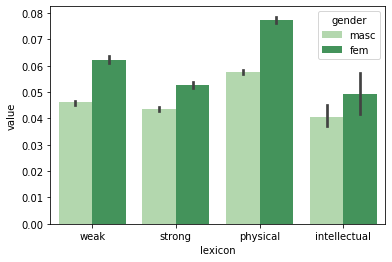

In [36]:
sns.barplot(x="lexicon", y="value", palette="Greens", hue="gender", data=df)

In [39]:
for k in word_counts: 
    print(k, '.........', word_counts[k].most_common(10))

('masc', 'weak') ......... [('afraid', 4483), ('need', 3842), ('old', 3282), ('married', 1487), ('willing', 1398), ('sorry', 1345), ('sick', 1323), ('tired', 1311), ('fallen', 1104), ('worried', 1051)]
('masc', 'strong') ......... [('sure', 9672), ('able', 9027), ('feel', 8484), ('keep', 1790), ('hurt', 1614), ('tall', 1028), ('strong', 942), ('smart', 754), ('big', 669), ('prepared', 514)]
('masc', 'physical') ......... [('wanted', 33481), ('able', 9027), ('feel', 8484), ('like', 5455), ('good', 3306), ('believe', 3277), ('young', 1969), ('keep', 1790), ('live', 1400), ('show', 991)]
('fem', 'strong') ......... [('feel', 7151), ('sure', 6983), ('able', 5695), ('keep', 1181), ('hurt', 697), ('strong', 691), ('smart', 567), ('tall', 439), ('prepared', 325), ('great', 234)]
('fem', 'weak') ......... [('afraid', 4016), ('need', 2816), ('old', 1892), ('married', 1423), ('tired', 1141), ('sick', 1096), ('sorry', 906), ('worried', 863), ('willing', 837), ('fallen', 825)]
('fem', 'physical') 

In [58]:
with open(LOGS + 'intellect_scores.json', 'r') as infile: 
    intellect_scores = Counter(json.load(infile))
print(intellect_scores.most_common(20), '\n')
with open(LOGS + 'physical_scores.json', 'r') as infile: 
    physical_scores = Counter(json.load(infile))
print(physical_scores.most_common(20), '\n')
with open(LOGS + 'strength_scores.json', 'r') as infile: 
    strength_scores = Counter(json.load(infile))
sorted_strength = strength_scores.most_common()
print(sorted_strength[:20], '\n')
print(sorted_strength[-20:], '\n')

[('intellectual', 0.565263569355011), ('aesthetic', 0.531465470790863), ('moral', 0.5274004936218262), ('artistic', 0.5271056890487671), ('progressive', 0.5259044766426086), ('values', 0.5202677845954895), ('ethical', 0.5201082825660706), ('spiritual', 0.5173299312591553), ('cultural', 0.5068851113319397), ('secular', 0.5044122338294983), ('religious', 0.500640332698822), ('imaginative', 0.5004410147666931), ('scientific', 0.49962708353996277), ('proletarian', 0.49812212586402893), ('bourgeois', 0.49639660120010376), ('marxist', 0.49501365423202515), ('revolutionary', 0.49355006217956543), ('political', 0.4931636452674866), ('radical', 0.49183112382888794), ('creative', 0.49179786443710327)] 

[('voluptuous', 0.3200930655002594), ('sensual', 0.29684576392173767), ('beautiful', 0.2961128056049347), ('gorgeous', 0.29289960861206055), ('flawless', 0.2922338545322418), ('manly', 0.2828841209411621), ('charming', 0.2827223837375641), ('seductive', 0.28182560205459595), ('womanly', 0.2810182

In [64]:
genpath = LOGS + 'generated_adj_noun/'
frames = []
gen_d = {'gender':[], 'lexicon':[], 'value':[]}
for f in os.listdir(genpath):
    title = f.replace('.tokens', '')
    gen_word = Counter() # (gender, lexicon) : value
    with open(genpath + f, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            w = contents[0]
            deprel = contents[3]
            hw = contents[5]
            storyid = contents[7]
            gender = contents[8]
            if deprel == 'amod': 
                keyword = w
            elif deprel == 'nsubj': 
                keyword = hw
            for k in lexicon_d: 
                if keyword in intellect_scores: 
                    gen_d['gender'].append(gender)
                    gen_d['lexicon'].append('intellectual')
                    gen_d['value'].append(intellect_scores[keyword])
            for k in lexicon_d: 
                if keyword in physical_scores: 
                    gen_d['gender'].append(gender)
                    gen_d['lexicon'].append('physical')
                    gen_d['value'].append(physical_scores[keyword])
            for k in lexicon_d: 
                if keyword in strength_scores: 
                    gen_d['gender'].append(gender)
                    gen_d['lexicon'].append('power')
                    gen_d['value'].append(strength_scores[keyword])

In [68]:
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,fem,intellectual,0.174617
1,fem,intellectual,0.174617
2,fem,intellectual,0.174617
3,fem,intellectual,0.174617
4,fem,physical,0.039984
...,...,...,...
66365443,fem,physical,-0.039087
66365444,fem,power,-0.184128
66365445,fem,power,-0.184128
66365446,fem,power,-0.184128


In [98]:
stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                        value                       ci95_hi   ci95_lo
                         mean     count       std                    
gender lexicon                                                       
fem    intellectual  0.000737   8589856  0.106225  0.000808  0.000666
       physical      0.030813   8589856  0.049761  0.030846  0.030779
       power        -0.110811   8589856  0.142279 -0.110716 -0.110906
masc   intellectual  0.002486  13531960  0.107917  0.002544  0.002429
       physical      0.028668  13531960  0.048085  0.028694  0.028643
       power        -0.099683  13531960  0.143592 -0.099607 -0.099760


In [95]:
fem_intell = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='intellectual')]['value'].to_list()
masc_intell = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='intellectual')]['value'].to_list()
print(mannwhitneyu(fem_intell, masc_intell, alternative="less"))
fem_phy = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='physical')]['value'].to_list()
masc_phy = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='physical')]['value'].to_list()
print(mannwhitneyu(fem_phy, masc_phy, alternative="greater"))
fem_power = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='power')]['value'].to_list()
masc_power = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='power')]['value'].to_list()
print(mannwhitneyu(fem_power, masc_power, alternative="less"))

MannwhitneyuResult(statistic=57723585004928.0, pvalue=3.0194349572576e-161)
MannwhitneyuResult(statistic=59383487858208.0, pvalue=0.0)
MannwhitneyuResult(statistic=55897334499728.0, pvalue=0.0)


In [73]:
genpath = LOGS + 'orig_adj_noun/'
frames = []
d = {'gender':[], 'lexicon':[], 'value':[]}
for f in os.listdir(genpath):
    title = f.replace('.tokens', '')
    gen_word = Counter() # (gender, lexicon) : value
    with open(genpath + f, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            w = contents[0]
            deprel = contents[3]
            hw = contents[5]
            storyid = contents[7]
            gender = contents[8]
            if deprel == 'amod': 
                keyword = w
            elif deprel == 'nsubj': 
                keyword = hw
            for k in lexicon_d: 
                if keyword in intellect_scores: 
                    d['gender'].append(gender)
                    d['lexicon'].append('intellectual')
                    d['value'].append(intellect_scores[keyword])
            for k in lexicon_d: 
                if keyword in physical_scores: 
                    d['gender'].append(gender)
                    d['lexicon'].append('physical')
                    d['value'].append(physical_scores[keyword])
            for k in lexicon_d: 
                if keyword in strength_scores: 
                    d['gender'].append(gender)
                    d['lexicon'].append('power')
                    d['value'].append(strength_scores[keyword])

In [99]:
df = pd.DataFrame.from_dict(d)
stats = df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                        value                      ci95_hi   ci95_lo
                         mean    count       std                    
gender lexicon                                                      
fem    intellectual  0.006983  1536796  0.109802  0.007156  0.006809
       physical      0.032353  1536796  0.051603  0.032435  0.032271
       power        -0.094603  1536796  0.148252 -0.094368 -0.094837
masc   intellectual  0.005929  2664132  0.111011  0.006062  0.005796
       physical      0.029760  2664132  0.049698  0.029819  0.029700
       power        -0.086722  2664132  0.148597 -0.086544 -0.086901


In [96]:
fem_intell = df.loc[(df.gender == 'fem') & (df.lexicon =='intellectual')]['value'].to_list()
masc_intell = df.loc[(df.gender == 'masc') & (df.lexicon =='intellectual')]['value'].to_list()
print(mannwhitneyu(fem_intell, masc_intell, alternative="less"))
fem_phy = df.loc[(df.gender == 'fem') & (df.lexicon =='physical')]['value'].to_list()
masc_phy = df.loc[(df.gender == 'masc') & (df.lexicon =='physical')]['value'].to_list()
print(mannwhitneyu(fem_phy, masc_phy, alternative="greater"))
fem_power = df.loc[(df.gender == 'fem') & (df.lexicon =='power')]['value'].to_list()
masc_power = df.loc[(df.gender == 'masc') & (df.lexicon =='power')]['value'].to_list()
print(mannwhitneyu(fem_power, masc_power, alternative="less"))

MannwhitneyuResult(statistic=2063869340432.0, pvalue=1.0)
MannwhitneyuResult(statistic=2101148614736.0, pvalue=0.0)
MannwhitneyuResult(statistic=1996995625040.0, pvalue=0.0)
